# Movie genre multi-label classification by overview


## Data Loading and Analysis

### Importing dependencies

In [37]:
import re
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score, hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud

### Loading in the dataset

In [38]:
data = pd.read_csv("tmdb_movies_2.csv", lineterminator='\n')
overviews = data["overview"]
genres = data["genres"].apply(eval)

### Movie genre distribution

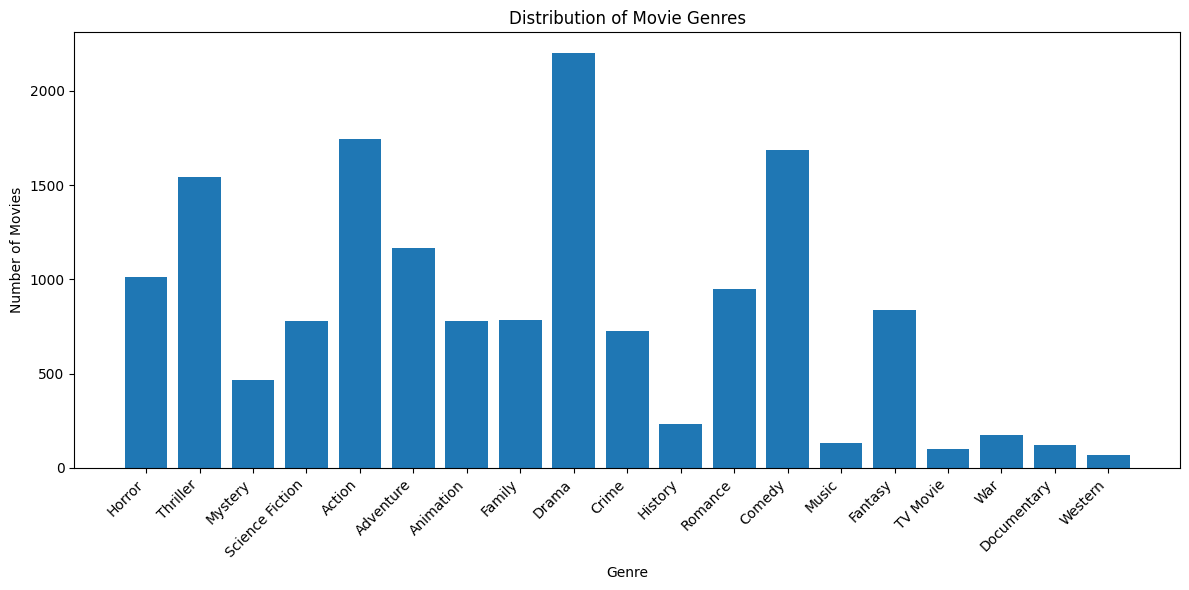

In [39]:
genres_all = []
for g in genres:
    genres_all.extend(g)

genres_counts = Counter(genres_all)
genres_counts_keys = list(genres_counts.keys())
genres_counts_vals = list(genres_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(genres_counts_keys, genres_counts_vals)
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.title("Distribution of Movie Genres")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Data Preparation

### Text preprocessing

In [40]:
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r"[^a-z0-9\s]", "", text)
        text = text.split()
        return text
    else:
        return []

overviews_processed = overviews.apply(preprocess_text)

### Tokenizing and Sequencing

In [41]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(overviews_processed)
sequences = tokenizer.texts_to_sequences(overviews_processed)
padded_sequences = pad_sequences(sequences, maxlen=200)

### One-hot encoding

In [42]:
mlb = MultiLabelBinarizer()
genre_labels = mlb.fit_transform(genres)

### Train/test split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, genre_labels, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

## Model training and evaluation

### Classifier model

In [44]:
class GenreClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout_prob):
        super(GenreClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        ltsm_output, (hidden, cell) = self.lstm(embedded)
        output = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        output = self.dropout(output)
        output = self.sigmoid(self.fc(output))
        return output

### Model Initialization

In [45]:
VOCAB_SIZE = tokenizer.num_words
EMBEDDING_DIM = 128
HIDDEN_DIM = 64
OUTPUT_DIM = y_train.shape[1]
DROPOUT_PROB = 0.2

model = GenreClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT_PROB)

### Model Training

In [46]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

epochs = 20
batch_size = 32

for epoch in range(epochs):
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        targets = y_train[i:i+batch_size]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/20, Loss: 0.3302
Epoch 2/20, Loss: 0.3115
Epoch 3/20, Loss: 0.2762
Epoch 4/20, Loss: 0.2491
Epoch 5/20, Loss: 0.2277
Epoch 6/20, Loss: 0.2026
Epoch 7/20, Loss: 0.1777
Epoch 8/20, Loss: 0.1609
Epoch 9/20, Loss: 0.1577
Epoch 10/20, Loss: 0.1450
Epoch 11/20, Loss: 0.1269
Epoch 12/20, Loss: 0.1158
Epoch 13/20, Loss: 0.1261
Epoch 14/20, Loss: 0.1085
Epoch 15/20, Loss: 0.1029
Epoch 16/20, Loss: 0.0985
Epoch 17/20, Loss: 0.0892
Epoch 18/20, Loss: 0.0837
Epoch 19/20, Loss: 0.0753
Epoch 20/20, Loss: 0.0735


### Model Evaluation

In [47]:
with torch.no_grad():
    model.eval()
    test_outputs = model(X_test)
    pred = (test_outputs > 0.5).int().numpy()
    test_loss = criterion(test_outputs, y_test)
    hamming = hamming_loss(y_test.numpy(), pred)
    f1_micro = f1_score(y_test.numpy(), pred, average='micro')
    f1_macro = f1_score(y_test.numpy(), pred, average='macro')
    print(f"Test Loss: {test_loss.item():.4f}")
    print(f"Hamming Loss: {hamming:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")

Test Loss: 0.3929
Hamming Loss: 0.1348
F1 Score (Macro): 0.2630


## Prediction

### Predict genre function

In [48]:
def predict_genre(overview):
    processed_overview = preprocess_text(overview)
    seq = tokenizer.texts_to_sequences([processed_overview])
    padded_seq = pad_sequences(seq, maxlen=200)
    input_tensor = torch.tensor(padded_seq, dtype=torch.long)
    with torch.no_grad():
        model.eval()
        prediction = model(input_tensor)

    predicted_probs = (prediction > 0.5).int().numpy()
    predicted_genres = mlb.inverse_transform(predicted_probs)
    return predicted_genres

### Predict genre in action

In [56]:
overviews = [
    "A banker convicted of uxoricide forms a friendship over a quarter century with a hardened convict, while maintaining his innocence and trying to remain hopeful through simple compassion.",
    "When a menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman, James Gordon and Harvey Dent must work together to put an end to the madness.",
    "A family heads to an isolated hotel for the winter, where a sinister presence influences the father into violence. At the same time, his psychic son sees horrifying forebodings from both the past and the future."
    ]

for o in overviews:
    predicted_genres = predict_genre(o)
    print(f"Input Overview: '{o}'\nGenres Predicted: {predicted_genres}\n")

Input Overview: 'A banker convicted of uxoricide forms a friendship over a quarter century with a hardened convict, while maintaining his innocence and trying to remain hopeful through simple compassion.'
Genres Predicted: [('Crime', 'Drama', 'Thriller')]

Input Overview: 'When a menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman, James Gordon and Harvey Dent must work together to put an end to the madness.'
Genres Predicted: [('Action', 'Crime')]

Input Overview: 'A family heads to an isolated hotel for the winter, where a sinister presence influences the father into violence. At the same time, his psychic son sees horrifying forebodings from both the past and the future.'
Genres Predicted: [('Horror', 'Mystery', 'Thriller')]

